# Group 14 - Project FP01
## Time series anomaly detection - LSTM-ED

This project aims at investigating the current state-of-the-arts TAD scenario.

In [1]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from dataset import *
from plots import *
from metrics import *

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [4]:

#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

# COLLISION LABEL
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp_v2.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')

collisions_adjusted_rec_1 = collision_rec1.Timestamp - pd.to_timedelta([2] * len(collision_rec1.Timestamp), 'h')
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collisions_init1 = collision_rec1[collision_rec1['Inizio/fine'] == "i"].Timestamp

collision_rec5 = pd.read_excel(xls, 'rec5')
collisions_adjusted_rec_5 = collision_rec5.Timestamp - pd.to_timedelta([2] * len(collision_rec5.Timestamp), 'h')
collision_rec5['Timestamp'] = collisions_adjusted_rec_5
collisions_init5 = collision_rec5[collision_rec5['Inizio/fine'] == "i"].Timestamp

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Exctraction

In [5]:
start_time = time.time()
frequency = 1/float(freq)
print(frequency)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int, save_dir="../features/df_features/LSTM_ED/")
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision, save_dir="../features/df_features_collisions/LSTM_ED/")
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1, save_dir="../features/df_features_collisions_1/LSTM_ED/")
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5, save_dir="../features/df_features_collisions_5/LSTM_ED/")
print("--- %s seconds ---" % (time.time() - start_time))

10.0
Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Features saved to ../features/df_features/LSTM_ED/features_statistical_10.0.csv.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Features saved to ../features/df_features_collisions/LSTM_ED/features_statistical_10.0.csv.
Computing features.


Features saved to ../features/df_features_collisions_1/LSTM_ED/features_statistical_10.0.csv.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Features saved to ../features/df_features_collisions_5/LSTM_ED/features_statistical_10.0.csv.
--- 156.3879234790802 seconds ---


In [6]:
collisions_zones = find_collisions_zones(collisions)
collisions_zones_1 = find_collisions_zones(collision_rec1)
collisions_zones_5 = find_collisions_zones(collision_rec5)

In [7]:
X_train, y_train, X_test, y_test, X_test_start_end = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1, X_test_start_end1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5,  X_test_start_end5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

In [8]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_init1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_init5)

In [9]:
y_collision = df_with_labels['is_collision']
y_collision_1 = df_with_labels_1['is_collision']
y_collision_5 = df_with_labels_5['is_collision']

In [10]:
df_features_collision.drop(columns=['is_collision'], inplace=True)
df_features_collision_1.drop(columns=['is_collision'], inplace=True)
df_features_collision_5.drop(columns=['is_collision'], inplace=True)

In [11]:
np.count_nonzero(y_collision), np.count_nonzero(y_collision_1), np.count_nonzero(y_collision_5)

(105, 35, 70)


## LSTM-ED

In [12]:
from algorithms.lstm_enc_dec_axl import LSTMED

classifier = LSTMED(
    name='LSTM-ED',
    num_epochs=100,
    batch_size=64,
    lr=1e-4,
    hidden_size=64,
    sequence_length=100,
    train_gaussian_percentage=0.25,
    n_layers=(2, 2),
    use_bias=(True, True),
    dropout=(0.1, 0.1),
    seed=42,
    gpu=None,              # Set to None for CPU, or specify GPU index if available
    details=True
)
# Train the LSTM on normal data
classifier.fit(X_train)
print("LSTM-ED training completed.")


100%|██████████| 100/100 [20:45<00:00, 12.45s/it]


LSTM-ED training completed.


In [13]:
y_test_predict = classifier.predict(X_test)

In [14]:
len(y_test_predict)

306

In [15]:
anomaly_scores = predict_anomaly_score(X_test, classifier)
anomaly_scores1 = predict_anomaly_score(X_test1, classifier)
anomaly_scores5 = predict_anomaly_score(X_test5, classifier)

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [16]:
len(anomaly_scores), len(anomaly_scores1), len(anomaly_scores5)

(306, 164, 141)

In [17]:
thresholds = compute_various_thresholds(anomaly_scores)
thresholds_1 = compute_various_thresholds(anomaly_scores1)
thresholds_5 = compute_various_thresholds(anomaly_scores5)

Number of anomalies detected: 13 with threshold 3403.694552069677, std
Number of anomalies detected: 118 with threshold 1302.1202641464124, mad
Number of anomalies detected: 16 with threshold 3331.4708102669547, percentile
Number of anomalies detected: 2 with threshold 4098.168210078177, IQR

Number of anomalies detected: 10 with threshold 2646.9801031165644, std
Number of anomalies detected: 47 with threshold 1262.589005200235, mad
Number of anomalies detected: 9 with threshold 2813.5000999444874, percentile
Number of anomalies detected: 37 with threshold 1345.189612998002, IQR

Number of anomalies detected: 0 with threshold 3928.453687951973, std
Number of anomalies detected: 70 with threshold 2086.9010565515314, mad
Number of anomalies detected: 8 with threshold 3516.806075352678, percentile
Number of anomalies detected: 0 with threshold 5553.893773445228, IQR



### Anomaly Detection

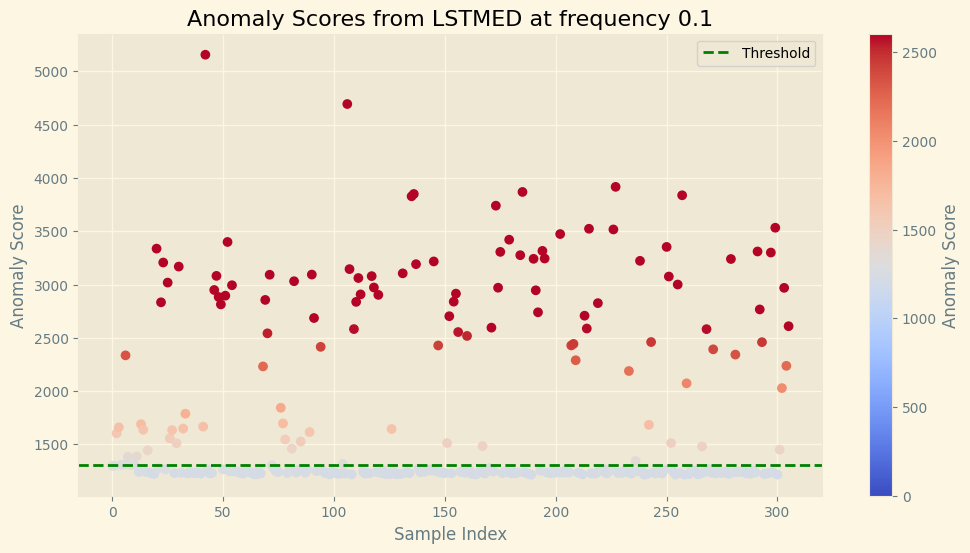

Number of anomalies detected: 118


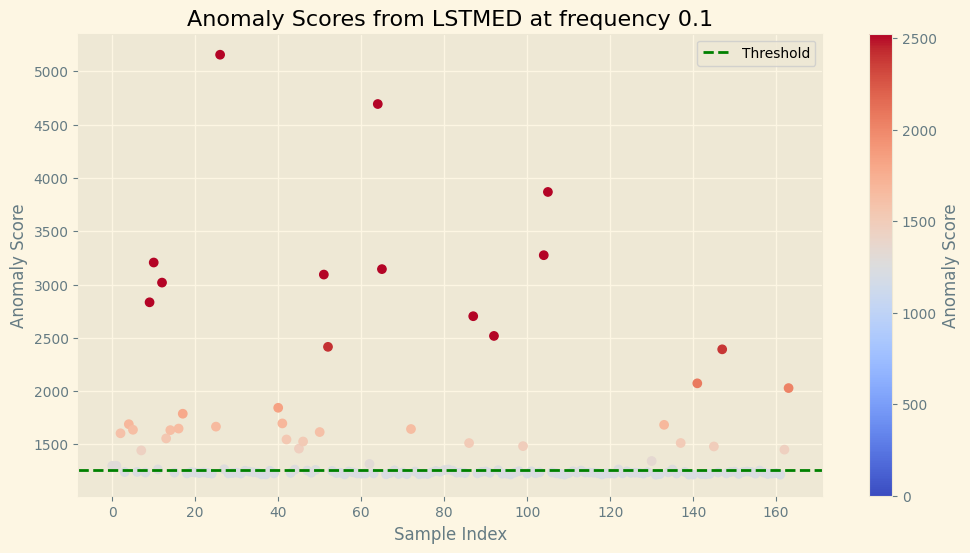

Number of anomalies detected: 47


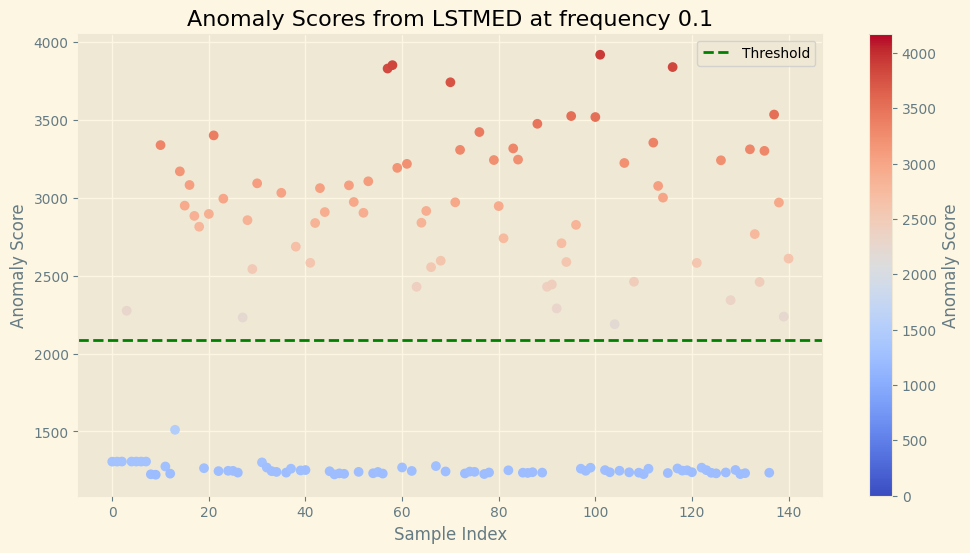

Number of anomalies detected: 70


In [18]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, thresholds[1])
anomalies_detected1 = plot_anomalies(anomaly_scores1, freq, thresholds_1[1])
anomalies_detected5 = plot_anomalies(anomaly_scores5, freq, thresholds_5[1])

In [29]:
def compute_metrics(anomaly_scores, y_test, threshold):
    
    print(f"Threshold: {threshold:.4f}")
    
    roc_auc = roc_auc_score(y_test, anomaly_scores)

    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    # Calculate F1 score
    f1 = f1_score(y_test, anomaly_scores > threshold)
    print(f"F1 Score: {f1:.4f}")
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, anomaly_scores > threshold)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Calculate precision
    precision = precision_score(y_test, anomaly_scores > threshold)
    print(f"Precision: {precision:.4f}")
    
    # Calculate recall
    recall = recall_score(y_test, anomaly_scores > threshold)
    print(f"Recall: {recall:.4f}")
    
    print(classification_report(y_test, anomaly_scores > threshold))

In [33]:
compute_metrics(anomaly_scores, y_collision, thresholds[1])
print("############################################")
compute_metrics(anomaly_scores1, y_collision_1, thresholds_1[1])
print("############################################")
compute_metrics(anomaly_scores5, y_collision_5, thresholds_5[1])

ROC AUC Score: 0.9966
Threshold: 1302.1203
F1 Score: 0.9417
Accuracy: 0.9575
Precision: 0.8898
Recall: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       201
           1       0.89      1.00      0.94       105

    accuracy                           0.96       306
   macro avg       0.94      0.97      0.95       306
weighted avg       0.96      0.96      0.96       306

############################################
ROC AUC Score: 0.9945
Threshold: 1262.5890
F1 Score: 0.8537
Accuracy: 0.9268
Precision: 0.7447
Recall: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       129
           1       0.74      1.00      0.85        35

    accuracy                           0.93       164
   macro avg       0.87      0.95      0.90       164
weighted avg       0.95      0.93      0.93       164

############################################
ROC AUC Score: 0.9992
Threshold: 208

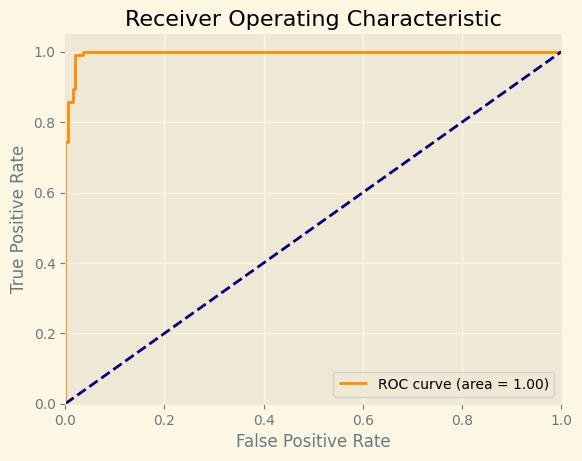

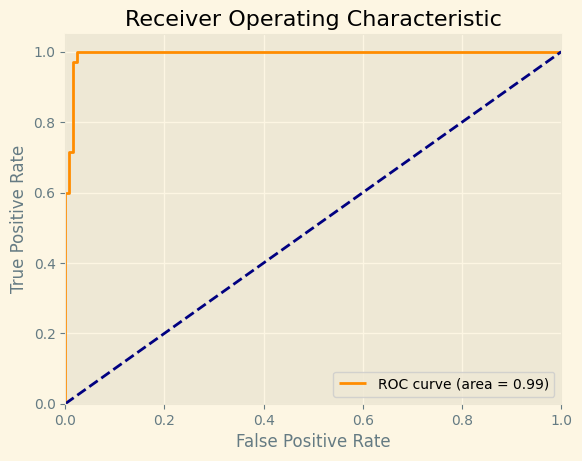

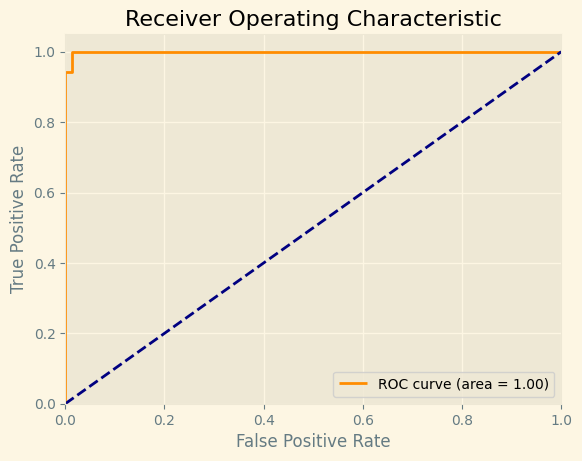

In [31]:
plot_roc_curve(y_collision, anomaly_scores)
plot_roc_curve(y_collision_1, anomaly_scores1)
plot_roc_curve(y_collision_5, anomaly_scores5)

## Map anomalies to original time series

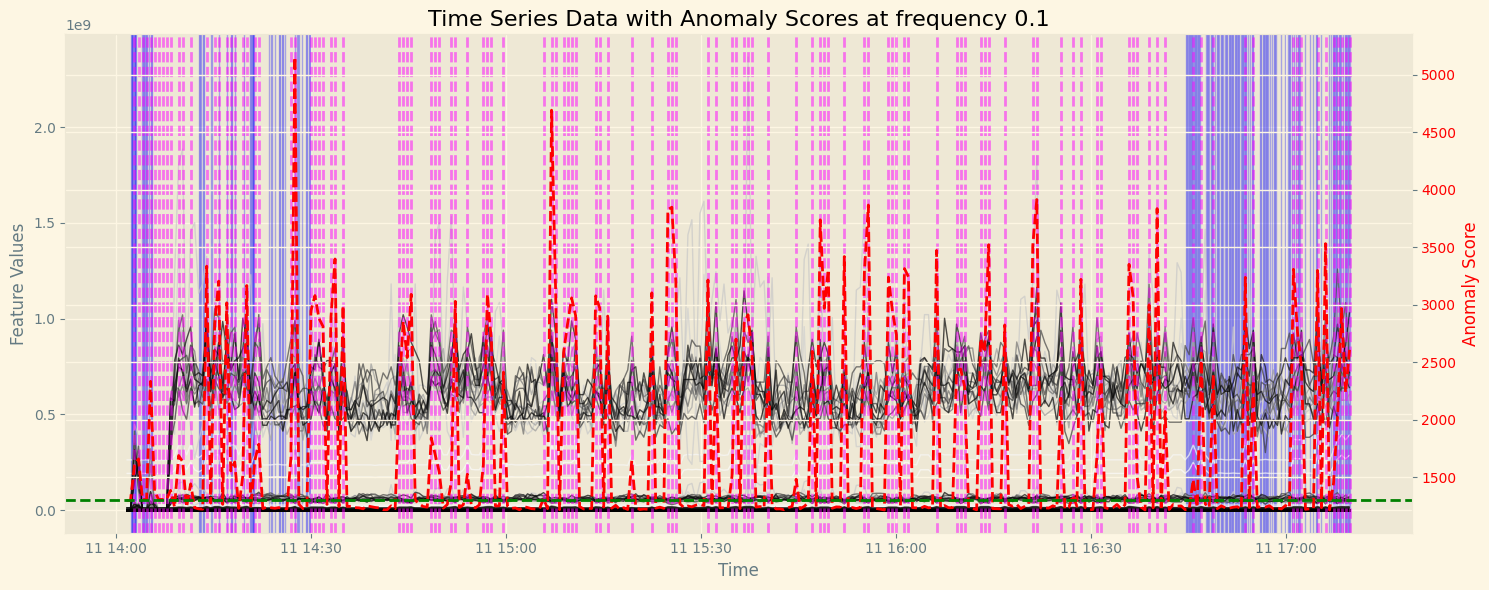

Top 118 Anomalies:
                       timestamp  anomaly_score  \
0  2022-08-11 14:27:30.161783606    5156.366590   
0  2022-08-11 15:07:00.474596721    4693.780692   
0  2022-08-11 16:21:41.847259016    3916.514923   
0  2022-08-11 15:55:46.329475409    3868.588018   
0  2022-08-11 15:25:31.558727868    3849.644157   
..                           ...            ...   
10 2022-08-11 14:07:45.005377049    1307.206381   
8  2022-08-11 14:06:30.933101639    1307.206107   
5  2022-08-11 14:04:39.824688524    1307.080479   
9  2022-08-11 14:07:07.969239344    1307.022723   
4  2022-08-11 14:04:02.788550819    1306.757310   

    machine_nameKuka Robot_apparent_power-_Absolute energy  \
0                                        6.227296e+06        
0                                        7.374417e+06        
0                                        6.393057e+06        
0                                        6.590238e+06        
0                                        6.031295e+06     

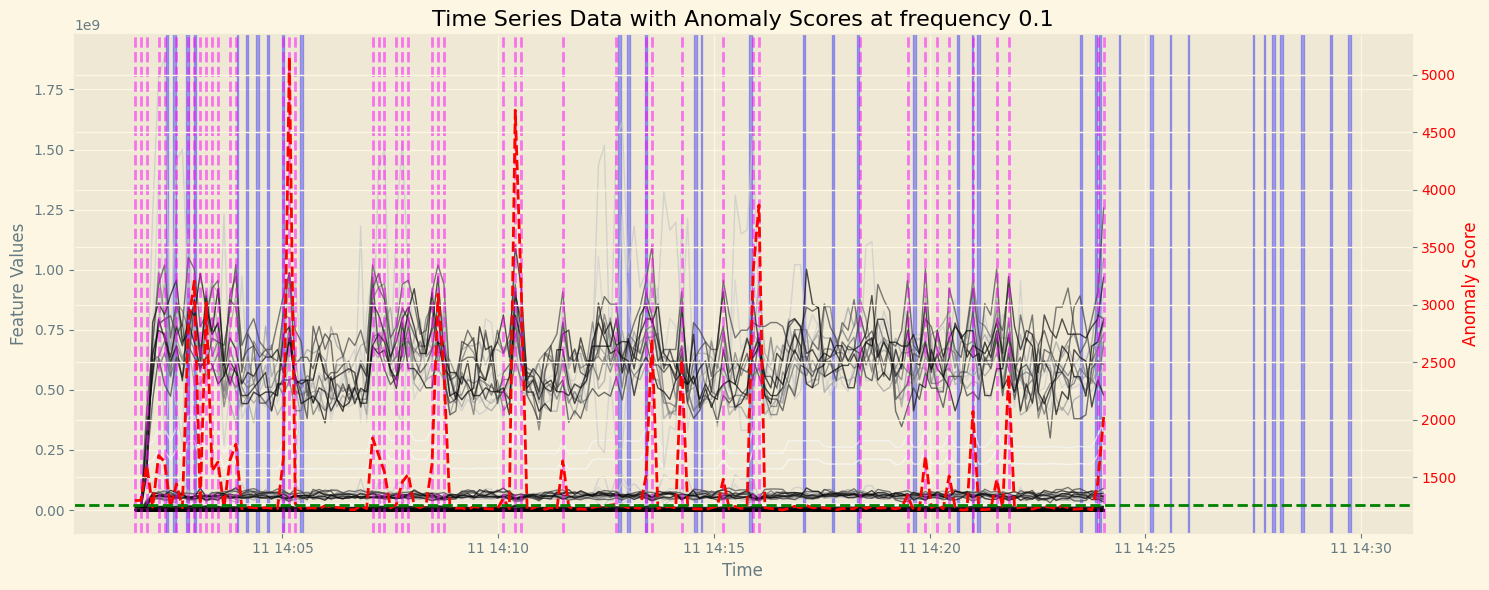

Top 47 Anomalies:
                timestamp  anomaly_score  \
0 2022-08-11 14:05:09.560    5156.366612   
0 2022-08-11 14:10:23.668    4693.780701   
0 2022-08-11 14:16:02.574    3868.587650   
0 2022-08-11 14:15:54.308    3275.106338   
0 2022-08-11 14:02:57.304    3206.443390   
0 2022-08-11 14:10:31.934    3144.512431   
0 2022-08-11 14:08:36.210    3093.287119   
0 2022-08-11 14:03:13.836    3017.970680   
0 2022-08-11 14:02:49.038    2833.076917   
0 2022-08-11 14:13:33.786    2702.564801   
0 2022-08-11 14:14:15.116    2517.522633   
0 2022-08-11 14:08:44.476    2415.084956   
0 2022-08-11 14:21:49.746    2391.851081   
0 2022-08-11 14:21:00.150    2072.715270   
0 2022-08-11 14:24:02.002    2028.075271   
0 2022-08-11 14:07:05.284    1843.181438   
0 2022-08-11 14:03:55.166    1787.425191   
0 2022-08-11 14:07:13.550    1696.443763   
0 2022-08-11 14:02:07.708    1689.271554   
0 2022-08-11 14:19:54.022    1683.163528   
0 2022-08-11 14:05:01.294    1666.304928   
0 2022-08-11 1

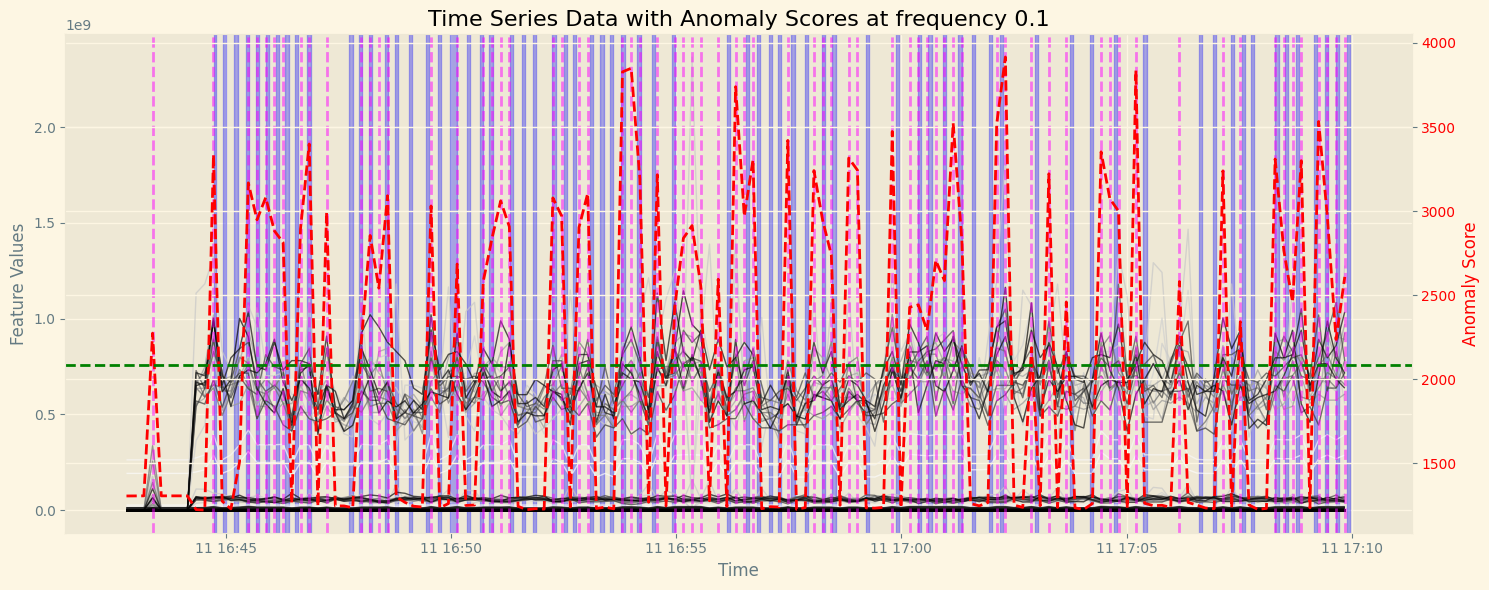

Top 70 Anomalies:
                       timestamp  anomaly_score  \
0  2022-08-11 17:02:18.519778571    3916.514552   
0  2022-08-11 16:53:59.999585714    3849.644820   
0  2022-08-11 17:05:12.422171428    3837.406311   
0  2022-08-11 16:53:48.406092857    3827.981687   
0  2022-08-11 16:56:19.121500000    3739.799726   
..                           ...            ...   
0  2022-08-11 17:00:34.178342857    2289.319533   
3  2022-08-11 16:43:22.357478571    2274.425893   
0  2022-08-11 17:09:39.072507142    2236.896256   
0  2022-08-11 16:48:00.601307142    2231.338870   
0  2022-08-11 17:02:53.300257142    2188.252905   

    machine_nameKuka Robot_apparent_power-_Absolute energy  \
0                                        6.393057e+06        
0                                        6.031295e+06        
0                                        6.636510e+06        
0                                        6.076420e+06        
0                                        5.434442e+06      

In [21]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq, thresholds[1], collisions_zones , X_test_start_end)
plot_anomalies_over_time(X_test1, anomaly_scores1, anomalies_detected1, freq, thresholds_1[1], collisions_zones_1, X_test_start_end1)
plot_anomalies_over_time(X_test5, anomaly_scores5, anomalies_detected5, freq, thresholds_5[1], collisions_zones_5, X_test_start_end5)